<a href="https://colab.research.google.com/github/Kr-Panghu/UNN-on-MNIST/blob/main/UNN2_GPUVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [1]:
import numpy as np
import os, sys 
import random 
import matplotlib.pyplot as plt
import copy
from torchvision.transforms import ToTensor
import torch 
from torch import linalg as LA
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.datasets as datasets
from tqdm.notebook import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Network

In [3]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        # defining fully connected layers
        self.fc1 = nn.Linear(784, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200) # 3 hidden layer
        self.fc4 = nn.Linear(200,10)

    def forward(self, x):
        # flatten the input to (batch_size, 28 *28)
        x = x.view(x.size(0), -1)       
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        output = self.fc4(x)
        return output    

## Load Data

In [4]:
mnist_trainset = datasets.MNIST(root='/content/drive/MyDrive/UNN_for_MNIST', train=True, download=True, transform=ToTensor())
mnist_testset = datasets.MNIST(root='/content/drive/MyDrive/UNN_for_MNIST', train=False, download=True, transform=ToTensor())

In [5]:
batch_size = 32
torch.manual_seed(2045)
trainset, valset = random_split(mnist_trainset, (50000 ,10000))

train_loader = torch.utils.data.DataLoader(
                 dataset=trainset,
                 batch_size=batch_size,
                 shuffle=True
                 )

val_loader = torch.utils.data.DataLoader(
                 dataset= valset,
                 batch_size=1,
                 shuffle=True
                 )

test_loader = torch.utils.data.DataLoader(
                dataset=mnist_testset,
                batch_size=batch_size,
                shuffle= True
                )

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Training

In [7]:
# Model 
Net = DNN()
Net.to(device)

# Define Loss function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Net.parameters(), lr = 0.001, weight_decay = 0.001)
# scheduler = StepLR(optimizer, step_size=1, gamma=0.99) 

train_losses = []
validation_losses = []

train_accs = []
val_accs = []

max_epochs = 10

# Loop over epochs
for epoch in tqdm(range(max_epochs)):
    
    running_trainloss, running_valloss, running_loss, train_acc = 0.0, 0.0, 0.0, 0.0
    train_cnt, val_cnt = 0, 0

    # Training
    for train_data, train_labels in tqdm(train_loader):
        # Transfer to GPU
        train_data, train_labels = train_data.to(device), train_labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Model computations
        # forward + backward + optimize
        batch_train_outputs = Net(train_data)
        # print(batch_train_outputs.shape, train_labels.shape)
        # break
        loss = criterion(batch_train_outputs, train_labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_trainloss += loss.item()
        running_loss += loss.item()

        train_acc += torch.sum(torch.argmax(batch_train_outputs, dim =1) ==  train_labels.long()) / torch.numel(train_labels)

        if train_cnt % 100 == 99:    # print every 10 mini-batches
            print("Cost of Train data after %i iterations in epoch %i : %f" %(train_cnt + 1,epoch + 1, running_loss / 100))
            running_loss = 0.0

        train_cnt += 1
    
    # # Validation
    # running_loss, val_acc = 0.0, 0.0

    # with torch.set_grad_enabled(False):
    #     for val_data, val_labels in tqdm(val_loader):
    #         # Transfer to GPU
    #         val_data, val_labels = val_data.to(device), val_labels.to(device)
            
    #         # Model computations
    #         # forward + backward + optimize
    #         batch_outputs = Net(val_data)
            
    #         val_loss = criterion(batch_outputs, val_labels.long())

    #         running_valloss += val_loss.item()
    #         running_loss += val_loss.item()

    #         val_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  val_labels.long()) / torch.numel(val_labels)

    #         if val_cnt % 100 == 99:    # print every 10 mini-batches
    #             print("Cost of Validation data after %i iterations in epoch %i : %f" %(val_cnt + 1,epoch + 1, running_loss / 100))
    #             running_loss = 0.0

    #         val_cnt += 1
    
    # scheduler.step()      
    train_losses.append(running_trainloss / train_cnt)
    train_accs.append(train_acc / train_cnt * 100)
    # validation_losses.append(running_valloss / val_cnt)
    # val_accs.append(val_acc / val_cnt * 100)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 1 : 2.297571
Cost of Train data after 200 iterations in epoch 1 : 1.715478
Cost of Train data after 300 iterations in epoch 1 : 1.235978
Cost of Train data after 400 iterations in epoch 1 : 0.933976
Cost of Train data after 500 iterations in epoch 1 : 0.785239
Cost of Train data after 600 iterations in epoch 1 : 0.714461
Cost of Train data after 700 iterations in epoch 1 : 0.648863
Cost of Train data after 800 iterations in epoch 1 : 0.583658
Cost of Train data after 900 iterations in epoch 1 : 0.568371
Cost of Train data after 1000 iterations in epoch 1 : 0.532121
Cost of Train data after 1100 iterations in epoch 1 : 0.515789
Cost of Train data after 1200 iterations in epoch 1 : 0.481122
Cost of Train data after 1300 iterations in epoch 1 : 0.469770
Cost of Train data after 1400 iterations in epoch 1 : 0.450483
Cost of Train data after 1500 iterations in epoch 1 : 0.445702


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 2 : 0.437964
Cost of Train data after 200 iterations in epoch 2 : 0.429941
Cost of Train data after 300 iterations in epoch 2 : 0.429782
Cost of Train data after 400 iterations in epoch 2 : 0.408857
Cost of Train data after 500 iterations in epoch 2 : 0.410954
Cost of Train data after 600 iterations in epoch 2 : 0.383728
Cost of Train data after 700 iterations in epoch 2 : 0.405783
Cost of Train data after 800 iterations in epoch 2 : 0.362222
Cost of Train data after 900 iterations in epoch 2 : 0.383827
Cost of Train data after 1000 iterations in epoch 2 : 0.373396
Cost of Train data after 1100 iterations in epoch 2 : 0.379079
Cost of Train data after 1200 iterations in epoch 2 : 0.365113
Cost of Train data after 1300 iterations in epoch 2 : 0.333768
Cost of Train data after 1400 iterations in epoch 2 : 0.338523
Cost of Train data after 1500 iterations in epoch 2 : 0.337197


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 3 : 0.352231
Cost of Train data after 200 iterations in epoch 3 : 0.317282
Cost of Train data after 300 iterations in epoch 3 : 0.331285
Cost of Train data after 400 iterations in epoch 3 : 0.317560
Cost of Train data after 500 iterations in epoch 3 : 0.310451
Cost of Train data after 600 iterations in epoch 3 : 0.307809
Cost of Train data after 700 iterations in epoch 3 : 0.291211
Cost of Train data after 800 iterations in epoch 3 : 0.314647
Cost of Train data after 900 iterations in epoch 3 : 0.312447
Cost of Train data after 1000 iterations in epoch 3 : 0.273521
Cost of Train data after 1100 iterations in epoch 3 : 0.321949
Cost of Train data after 1200 iterations in epoch 3 : 0.277882
Cost of Train data after 1300 iterations in epoch 3 : 0.285103
Cost of Train data after 1400 iterations in epoch 3 : 0.294844
Cost of Train data after 1500 iterations in epoch 3 : 0.292047


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 4 : 0.284404
Cost of Train data after 200 iterations in epoch 4 : 0.266828
Cost of Train data after 300 iterations in epoch 4 : 0.271331
Cost of Train data after 400 iterations in epoch 4 : 0.278311
Cost of Train data after 500 iterations in epoch 4 : 0.294200
Cost of Train data after 600 iterations in epoch 4 : 0.271932
Cost of Train data after 700 iterations in epoch 4 : 0.290668
Cost of Train data after 800 iterations in epoch 4 : 0.259041
Cost of Train data after 900 iterations in epoch 4 : 0.285138
Cost of Train data after 1000 iterations in epoch 4 : 0.264996
Cost of Train data after 1100 iterations in epoch 4 : 0.266127
Cost of Train data after 1200 iterations in epoch 4 : 0.285025
Cost of Train data after 1300 iterations in epoch 4 : 0.283793
Cost of Train data after 1400 iterations in epoch 4 : 0.274885
Cost of Train data after 1500 iterations in epoch 4 : 0.299000


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 5 : 0.267824
Cost of Train data after 200 iterations in epoch 5 : 0.263334
Cost of Train data after 300 iterations in epoch 5 : 0.254550
Cost of Train data after 400 iterations in epoch 5 : 0.233601
Cost of Train data after 500 iterations in epoch 5 : 0.255689
Cost of Train data after 600 iterations in epoch 5 : 0.255057
Cost of Train data after 700 iterations in epoch 5 : 0.237303
Cost of Train data after 800 iterations in epoch 5 : 0.273356
Cost of Train data after 900 iterations in epoch 5 : 0.270448
Cost of Train data after 1000 iterations in epoch 5 : 0.231594
Cost of Train data after 1100 iterations in epoch 5 : 0.263207
Cost of Train data after 1200 iterations in epoch 5 : 0.250447
Cost of Train data after 1300 iterations in epoch 5 : 0.248318
Cost of Train data after 1400 iterations in epoch 5 : 0.264115
Cost of Train data after 1500 iterations in epoch 5 : 0.287335


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 6 : 0.240347
Cost of Train data after 200 iterations in epoch 6 : 0.235317
Cost of Train data after 300 iterations in epoch 6 : 0.242685
Cost of Train data after 400 iterations in epoch 6 : 0.259674
Cost of Train data after 500 iterations in epoch 6 : 0.242792
Cost of Train data after 600 iterations in epoch 6 : 0.255058
Cost of Train data after 700 iterations in epoch 6 : 0.234291
Cost of Train data after 800 iterations in epoch 6 : 0.235485
Cost of Train data after 900 iterations in epoch 6 : 0.232929
Cost of Train data after 1000 iterations in epoch 6 : 0.246585
Cost of Train data after 1100 iterations in epoch 6 : 0.255479
Cost of Train data after 1200 iterations in epoch 6 : 0.235059
Cost of Train data after 1300 iterations in epoch 6 : 0.233132
Cost of Train data after 1400 iterations in epoch 6 : 0.230621
Cost of Train data after 1500 iterations in epoch 6 : 0.252588


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 7 : 0.206904
Cost of Train data after 200 iterations in epoch 7 : 0.213578
Cost of Train data after 300 iterations in epoch 7 : 0.248634
Cost of Train data after 400 iterations in epoch 7 : 0.240391
Cost of Train data after 500 iterations in epoch 7 : 0.219934
Cost of Train data after 600 iterations in epoch 7 : 0.241258
Cost of Train data after 700 iterations in epoch 7 : 0.234848
Cost of Train data after 800 iterations in epoch 7 : 0.222680
Cost of Train data after 900 iterations in epoch 7 : 0.237510
Cost of Train data after 1000 iterations in epoch 7 : 0.244471
Cost of Train data after 1100 iterations in epoch 7 : 0.240111
Cost of Train data after 1200 iterations in epoch 7 : 0.244474
Cost of Train data after 1300 iterations in epoch 7 : 0.230230
Cost of Train data after 1400 iterations in epoch 7 : 0.222406
Cost of Train data after 1500 iterations in epoch 7 : 0.235687


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 8 : 0.221273
Cost of Train data after 200 iterations in epoch 8 : 0.235612
Cost of Train data after 300 iterations in epoch 8 : 0.206327
Cost of Train data after 400 iterations in epoch 8 : 0.215698
Cost of Train data after 500 iterations in epoch 8 : 0.236345
Cost of Train data after 600 iterations in epoch 8 : 0.229551
Cost of Train data after 700 iterations in epoch 8 : 0.233067
Cost of Train data after 800 iterations in epoch 8 : 0.233852
Cost of Train data after 900 iterations in epoch 8 : 0.222832
Cost of Train data after 1000 iterations in epoch 8 : 0.233899
Cost of Train data after 1100 iterations in epoch 8 : 0.219269
Cost of Train data after 1200 iterations in epoch 8 : 0.223332
Cost of Train data after 1300 iterations in epoch 8 : 0.206239
Cost of Train data after 1400 iterations in epoch 8 : 0.232655
Cost of Train data after 1500 iterations in epoch 8 : 0.220764


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 9 : 0.204955
Cost of Train data after 200 iterations in epoch 9 : 0.221957
Cost of Train data after 300 iterations in epoch 9 : 0.219462
Cost of Train data after 400 iterations in epoch 9 : 0.210751
Cost of Train data after 500 iterations in epoch 9 : 0.227101
Cost of Train data after 600 iterations in epoch 9 : 0.206256
Cost of Train data after 700 iterations in epoch 9 : 0.209496
Cost of Train data after 800 iterations in epoch 9 : 0.230552
Cost of Train data after 900 iterations in epoch 9 : 0.234874
Cost of Train data after 1000 iterations in epoch 9 : 0.216862
Cost of Train data after 1100 iterations in epoch 9 : 0.205210
Cost of Train data after 1200 iterations in epoch 9 : 0.218708
Cost of Train data after 1300 iterations in epoch 9 : 0.227622
Cost of Train data after 1400 iterations in epoch 9 : 0.248061
Cost of Train data after 1500 iterations in epoch 9 : 0.220377


  0%|          | 0/1563 [00:00<?, ?it/s]

Cost of Train data after 100 iterations in epoch 10 : 0.209072
Cost of Train data after 200 iterations in epoch 10 : 0.218471
Cost of Train data after 300 iterations in epoch 10 : 0.206237
Cost of Train data after 400 iterations in epoch 10 : 0.218856
Cost of Train data after 500 iterations in epoch 10 : 0.217208
Cost of Train data after 600 iterations in epoch 10 : 0.199830
Cost of Train data after 700 iterations in epoch 10 : 0.205756
Cost of Train data after 800 iterations in epoch 10 : 0.224853
Cost of Train data after 900 iterations in epoch 10 : 0.219632
Cost of Train data after 1000 iterations in epoch 10 : 0.216566
Cost of Train data after 1100 iterations in epoch 10 : 0.208288
Cost of Train data after 1200 iterations in epoch 10 : 0.215487
Cost of Train data after 1300 iterations in epoch 10 : 0.231012
Cost of Train data after 1400 iterations in epoch 10 : 0.223085
Cost of Train data after 1500 iterations in epoch 10 : 0.221427


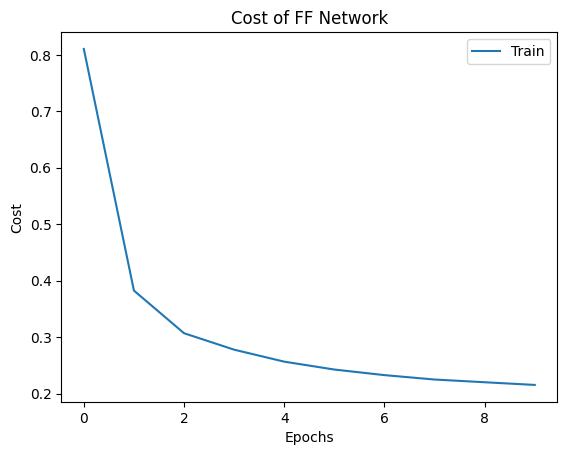

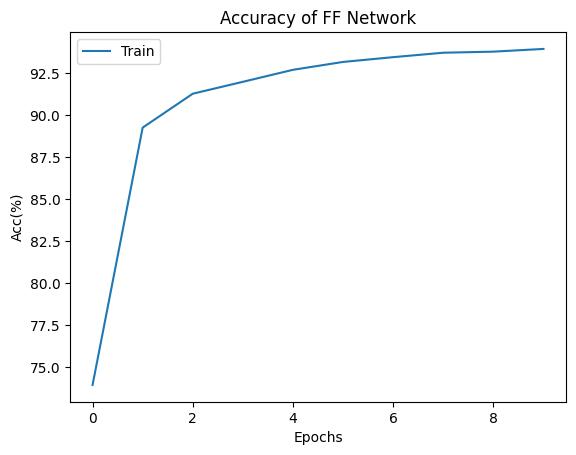

In [20]:
plot_cost, plot_acc = 1, 1
# plot the cost

if plot_cost:
    plt.plot(train_losses)
    # plt.plot(validation_losses)
    plt.title("Cost of FF Network")
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train"])
    plt.show()

train_accs = [tensor.item() for tensor in train_accs]

if plot_acc:
    plt.plot(train_accs)
    # plt.plot(val_accs)
    plt.title("Accuracy of FF Network")
    plt.ylabel('Acc(%)')
    plt.xlabel('Epochs')
    plt.legend(labels = ["Train"])
    plt.show()

## Test

In [21]:
# test
running_testloss, test_acc = 0.0, 0.0
test_cnt = 0

with torch.set_grad_enabled(False):
    for test_data, test_labels in tqdm(test_loader):
        # Transfer to GPU
        test_data, test_labels = test_data.to(device), test_labels.to(device)
        
        # Model computations
        # forward + backward + optimize
        batch_outputs = Net(test_data)
        
        test_loss = criterion(batch_outputs, test_labels.long())

        running_testloss += test_loss.item()

        test_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  test_labels.long()) / torch.numel(test_labels)

        # if test_cnt % 100 == 99:    # print every 10 mini-batches
        #     print("Cost of testidation data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_loss / 100))
        #     running_loss = 0.0

        test_cnt += 1

print((100 * test_acc / test_cnt).item() )

  0%|          | 0/313 [00:00<?, ?it/s]

94.4688491821289


Save the trained model

In [ ]:
PATH = '/content/drive/My Drive/PerFed_Net.pth'
torch.save(Net.state_dict(), PATH)

## Information Theoretic Measures

In [22]:
joint_prob_1st = torch.zeros((200,20), device = 'cuda')
joint_prob_2st = torch.zeros((200,20), device = 'cuda')
joint_prob_3st = torch.zeros((200,20), device = 'cuda')
class_probs = torch.zeros((10,1), device = 'cuda')
p_1st = torch.zeros((200,2), device = 'cuda')
p_2st = torch.zeros((200,2), device = 'cuda')
p_3st = torch.zeros((200,2), device = 'cuda')
N = 10000

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

with torch.set_grad_enabled(False):
    for val_data, val_labels in tqdm(val_loader):
        # Transfer to GPU
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        val_labels = int(val_labels)
        class_probs[val_labels] += 1
        
        # Model computations
        # forward + backward + optimize
        # flatten the input to (batch_size, 28 *28)
        val_data = val_data.view(val_data.size(0), -1)    

        x1 = torch.sigmoid(Net.fc1(val_data))
        t1 = (x1 > 0.5).int()
        joint_prob_1st[:,val_labels*2 ] += (t1 == 0).int().squeeze()
        joint_prob_1st[:,val_labels*2 + 1] += (t1 == 1).int().squeeze()
        p_1st[:,0] += (t1 == 0).int().squeeze()
        p_1st[:,1] += (t1 == 1).int().squeeze() 

        x2 = torch.sigmoid(Net.fc2(x1))
        t2 = (x2 > 0.5).int()
        joint_prob_2st[:,val_labels*2 ] += (t2 == 0).int().squeeze()
        joint_prob_2st[:,val_labels*2 + 1] += (t2 == 1).int().squeeze()        
        p_2st[:,0] += (t2 == 0).int().squeeze()
        p_2st[:,1] += (t2 == 1).int().squeeze()

        x3 = torch.sigmoid(Net.fc3(x2))
        t3 = (x3 > 0.5).int()
        joint_prob_3st[:,val_labels*2 ] += (t3 == 0).int().squeeze()
        joint_prob_3st[:,val_labels*2 + 1] += (t3 == 1).int().squeeze() 
        p_3st[:,0] += (t3 == 0).int().squeeze()
        p_3st[:,1] += (t3 == 1).int().squeeze()

joint_prob_1st = joint_prob_1st / N
joint_prob_2st = joint_prob_2st / N 
joint_prob_3st = joint_prob_3st / N
class_probs = class_probs / N
p_1st = p_1st / N 
p_2st = p_2st / N 
p_3st = p_3st / N

  0%|          | 0/10000 [00:00<?, ?it/s]

In [23]:
class_probs

tensor([[0.0972],
        [0.1106],
        [0.1011],
        [0.1008],
        [0.0985],
        [0.0889],
        [0.1013],
        [0.1026],
        [0.0994],
        [0.0996]], device='cuda:0')

In [24]:
sum(joint_prob_1st[0,:]), joint_prob_1st[0,:]

(tensor(1., device='cuda:0'),
 tensor([0.0972, 0.0000, 0.0185, 0.0921, 0.0899, 0.0112, 0.1002, 0.0006, 0.0909,
         0.0076, 0.0878, 0.0011, 0.1008, 0.0005, 0.0996, 0.0030, 0.0755, 0.0239,
         0.0970, 0.0026], device='cuda:0'))

In [25]:
sum(joint_prob_2st[0,:]), joint_prob_2st[0,:]

(tensor(1.0000, device='cuda:0'),
 tensor([9.0100e-02, 7.1000e-03, 1.1060e-01, 0.0000e+00, 1.0100e-01, 1.0000e-04,
         1.0070e-01, 1.0000e-04, 9.6400e-02, 2.1000e-03, 8.8700e-02, 2.0000e-04,
         1.0130e-01, 0.0000e+00, 5.3400e-02, 4.9200e-02, 9.9400e-02, 0.0000e+00,
         6.2300e-02, 3.7300e-02], device='cuda:0'))

In [26]:
sum(joint_prob_3st[0,:]), joint_prob_3st[0,:]

(tensor(1., device='cuda:0'),
 tensor([0.0972, 0.0000, 0.0534, 0.0572, 0.0998, 0.0013, 0.0983, 0.0025, 0.0075,
         0.0910, 0.0842, 0.0047, 0.1013, 0.0000, 0.0022, 0.1004, 0.0980, 0.0014,
         0.0039, 0.0957], device='cuda:0'))

In [27]:
p_1st[0,:]

tensor([0.8574, 0.1426], device='cuda:0')

In [28]:
p_2st[0,:]

tensor([0.9039, 0.0961], device='cuda:0')

In [29]:
p_3st[0,:]

tensor([0.6458, 0.3542], device='cuda:0')

In [30]:
Entropy_1st = - p_1st[:,0] * torch.log(p_1st[:,0]) - p_1st[:,1] * torch.log(p_1st[:,1])
Entropy_2st = - p_2st[:,0] * torch.log(p_2st[:,0]) - p_2st[:,1] * torch.log(p_2st[:,1])
Entropy_3st = - p_3st[:,0] * torch.log(p_3st[:,0]) - p_3st[:,1] * torch.log(p_3st[:,1])

Cond_Entropy_1st = torch.zeros((200,1), device = 'cuda')
Cond_Entropy_2st = torch.zeros((200,1), device = 'cuda')
Cond_Entropy_3st = torch.zeros((200,1), device = 'cuda')

for c in range(10):
    for t in range(2):
        Cond_Entropy_1st[:,0] += joint_prob_1st[:,c*2+t] * torch.log(joint_prob_1st[:,c*2+t] / class_probs[c,0])
        Cond_Entropy_2st[:,0] += joint_prob_2st[:,c*2+t] * torch.log(joint_prob_2st[:,c*2+t] / class_probs[c,0])
        Cond_Entropy_3st[:,0] += joint_prob_3st[:,c*2+t] * torch.log(joint_prob_3st[:,c*2+t] / class_probs[c,0])

MI_1st = Entropy_1st.unsqueeze(-1) - Cond_Entropy_1st
MI_2st = Entropy_2st.unsqueeze(-1) - Cond_Entropy_2st
MI_3st = Entropy_3st.unsqueeze(-1) - Cond_Entropy_3st

KL_sel_1st = torch.zeros((200,1), device = 'cuda')
KL_sel_2st = torch.zeros((200,1), device = 'cuda')
KL_sel_3st = torch.zeros((200,1), device = 'cuda')

def KL(cond_prob, prob):
    return torch.where(cond_prob != 0, cond_prob * torch.log(cond_prob / prob), torch.tensor([0.0], device = 'cuda')) 

for c in range(10):

    KL_sel_1st = torch.maximum(KL_sel_1st, torch.sum(KL((joint_prob_1st[:,c*2:(c+1)*2] / class_probs[c]),p_1st),dim = 1, keepdims = True))
    KL_sel_2st = torch.maximum(KL_sel_2st, torch.sum(KL((joint_prob_2st[:,c*2:(c+1)*2] / class_probs[c]),p_2st),dim = 1, keepdims = True))
    KL_sel_3st = torch.maximum(KL_sel_3st, torch.sum(KL((joint_prob_3st[:,c*2:(c+1)*2] / class_probs[c]),p_3st),dim = 1, keepdims = True))

In [ ]:
def KL(cond_prob, prob):
    return torch.where(cond_prob != 0, cond_prob * torch.log(cond_prob / prob), torch.tensor([0.0], device = 'cuda')) 

In [31]:
p_1st[6,:] 

tensor([1., 0.], device='cuda:0')

In [32]:
joint_prob_1st[6,0*2:(0+1)*2]

tensor([0.0972, 0.0000], device='cuda:0')

In [33]:
joint_prob_1st[6,0*2:(0+1)*2] / class_probs[0]

tensor([1., 0.], device='cuda:0')

In [34]:
(joint_prob_1st[6,0*2:(0+1)*2] / class_probs[0]) * torch.log((joint_prob_1st[6,0*2:(0+1)*2] / class_probs[0])/ p_1st[6,:])

tensor([0., nan], device='cuda:0')

In [35]:
torch.sum(KL((joint_prob_1st[:,0*2:(0+1)*2] / class_probs[0]),p_1st),dim = 1, keepdims = True)

tensor([[1.5385e-01],
        [0.0000e+00],
        [2.6085e-01],
        [2.7158e-01],
        [1.0771e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.2772e-01],
        [4.6592e-02],
        [0.0000e+00],
        [1.3711e-01],
        [0.0000e+00],
        [1.4697e-03],
        [0.0000e+00],
        [0.0000e+00],
        [3.3122e-02],
        [0.0000e+00],
        [9.2875e-02],
        [0.0000e+00],
        [4.7534e-01],
        [1.6253e-01],
        [1.0912e+00],
        [2.1084e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [5.0741e-02],
        [1.6215e-02],
        [8.7623e-02],
        [1.0714e-01],
        [2.3261e-01],
        [1.7193e-01],
        [0.0000e+00],
        [1.8329e-01],
        [0.0000e+00],
        [7.7765e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.3984e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.6216e+00],
        [1.4272e-01],
        [0.0000e+00],
        [1

In [ ]:
# def KL(a, b):
#     a = np.asarray(a, dtype=np.float)
#     b = np.asarray(b, dtype=np.float)

#     return np.sum(np.where(a != 0, a * np.log(a / b +0.001), 0))

In [36]:
joint_prob_1st[0,:]

tensor([0.0972, 0.0000, 0.0185, 0.0921, 0.0899, 0.0112, 0.1002, 0.0006, 0.0909,
        0.0076, 0.0878, 0.0011, 0.1008, 0.0005, 0.0996, 0.0030, 0.0755, 0.0239,
        0.0970, 0.0026], device='cuda:0')

In [37]:
KL_sel_1st

tensor([[1.1961e+00],
        [0.0000e+00],
        [9.9952e-01],
        [9.6278e-01],
        [8.7207e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.7173e+00],
        [5.1693e-01],
        [0.0000e+00],
        [5.8956e-01],
        [0.0000e+00],
        [1.4697e-03],
        [0.0000e+00],
        [0.0000e+00],
        [4.5899e-01],
        [0.0000e+00],
        [6.2012e-01],
        [0.0000e+00],
        [4.7534e-01],
        [8.1587e-01],
        [1.0912e+00],
        [8.4548e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [5.8488e-01],
        [1.6215e-02],
        [1.1721e+00],
        [1.6125e+00],
        [7.6253e-01],
        [8.0571e-01],
        [0.0000e+00],
        [8.0933e-01],
        [0.0000e+00],
        [7.7765e-01],
        [0.0000e+00],
        [0.0000e+00],
        [1.7800e+00],
        [0.0000e+00],
        [0.0000e+00],
        [1.6216e+00],
        [1.7135e+00],
        [0.0000e+00],
        [1

## Entropy, MI, KL Selctivity of Layers (Fig 2)

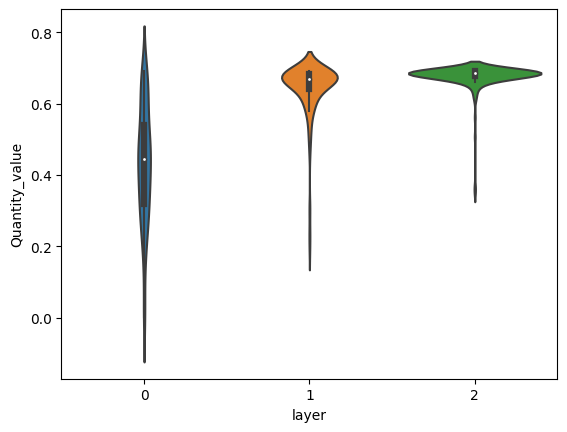

In [41]:
#Violin plot 
import seaborn as sns

_Entropy_1st = [tensor.item() for tensor in Entropy_1st]
_Entropy_2st = [tensor.item() for tensor in Entropy_2st]
_Entropy_3st = [tensor.item() for tensor in Entropy_3st]

ax = sns.violinplot(data= (_Entropy_1st, _Entropy_2st, _Entropy_3st))
ax.set_xlabel("layer")
ax.set_ylabel("Quantity_value") 
plt.show()

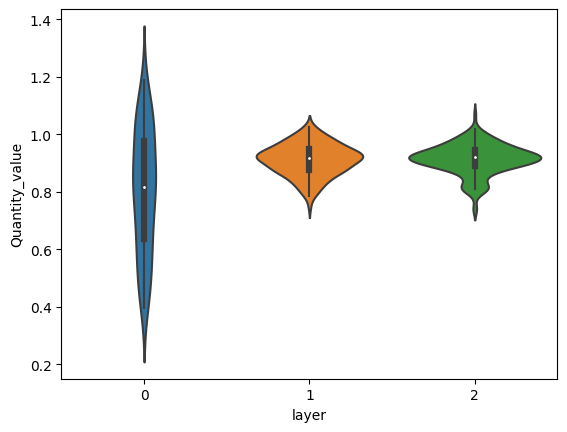

In [43]:
_MI_1st =  [tensor.item() for tensor in MI_1st]
_MI_2st =  [tensor.item() for tensor in MI_2st]
_MI_3st =  [tensor.item() for tensor in MI_3st]

ax = sns.violinplot(data= (_MI_1st, _MI_2st, _MI_3st))
ax.set_xlabel("layer")
ax.set_ylabel("Quantity_value")
plt.show()

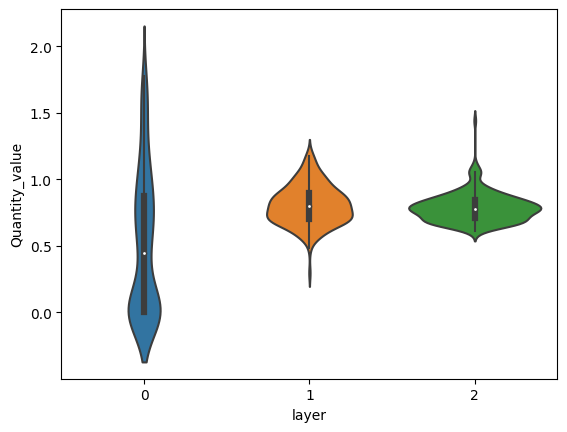

In [44]:
_KL_sel_1st =  [tensor.item() for tensor in KL_sel_1st]
_KL_sel_2st =  [tensor.item() for tensor in KL_sel_2st]
_KL_sel_3st =  [tensor.item() for tensor in KL_sel_3st]

ax = sns.violinplot(data= (_KL_sel_1st, _KL_sel_2st, _KL_sel_3st))
ax.set_xlabel("layer")
ax.set_ylabel("Quantity_value")
plt.show()

## Layer-wise Ablation (Fig 1) [bias balancing]

In [45]:
def cal_performance(model,test_loader, mask):
    running_testloss, test_acc = 0.0, 0.0
    test_cnt = 0

    with torch.set_grad_enabled(False):
        for test_data, test_labels in test_loader:
            # Transfer to GPU
            test_data, test_labels = test_data.to(device), test_labels.to(device)
            
            # Model computations
            # forward + backward + optimize
            test_data = test_data.view(test_data.size(0), -1)       
            x1 = torch.sigmoid(model.fc1(test_data))
            x1 = x1 * mask[0:200,:].T
            x2 = torch.sigmoid(model.fc2(x1))
            x2 = x2 * mask[200:400,:].T
            x3 = torch.sigmoid(model.fc3(x2))
            x3 = x3 * mask[400:,:].T
            batch_outputs = model.fc4(x3)

            test_loss = criterion(batch_outputs, test_labels.long())

            running_testloss += test_loss.item()

            test_acc += torch.sum(torch.argmax(batch_outputs, dim =1) ==  test_labels.long()) / torch.numel(test_labels)

            # if test_cnt % 100 == 99:    # print every 10 mini-batches
            #     print("Cost of testidation data after %i iterations in epoch %i : %f" %(test_cnt + 1,epoch + 1, running_loss / 100))
            #     running_loss = 0.0

            test_cnt += 1

    return (100 * test_acc / test_cnt).item() 

In [46]:
Entropy = torch.cat((Entropy_1st, Entropy_2st, Entropy_3st),0).unsqueeze(-1)
MI = torch.cat((MI_1st, MI_2st, MI_3st),0)
KL_sel = torch.cat((KL_sel_1st, KL_sel_2st, KL_sel_3st),0)
p = torch.cat((p_1st, p_2st, p_3st),0)

### First Layer

In [59]:
random_performances = []
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False)
    random_idx = torch.from_numpy(random_idx).cuda()
    mask1 = torch.ones((600,1), device='cuda')
    mask1[random_idx] = 0
    random_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [60]:
MI_performances = []
MI_bias_performances = []

for n_abl in tqdm(range(80)):

    idx = torch.topk(MI_1st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1)
    mask1 = torch.ones((600,1), device='cuda')
    mask1[idx] = 0
    MI_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

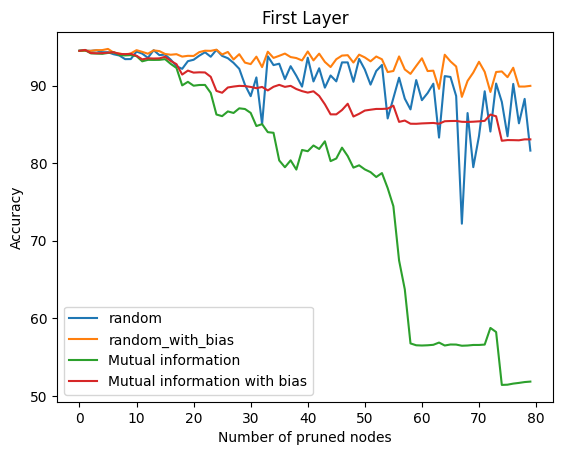

In [61]:
plt.plot(random_performances)
plt.plot(random_bias_performances)
plt.plot(MI_performances)
plt.plot(MI_bias_performances)
plt.title("First Layer")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "random_with_bias", "Mutual information", "Mutual information with bias"])
plt.show()

### Second layer

In [67]:
random_performances = []
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) + 200
    random_idx = torch.from_numpy(random_idx).cuda()
    mask1 = torch.ones((600,1), device='cuda')
    mask1[random_idx] = 0
    random_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [68]:
MI_performances = []
MI_bias_performances = []

for n_abl in tqdm(range(80)):

    idx = torch.topk(MI_2st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 200
    mask1 = torch.ones((600,1), device='cuda')
    mask1[idx] = 0
    MI_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

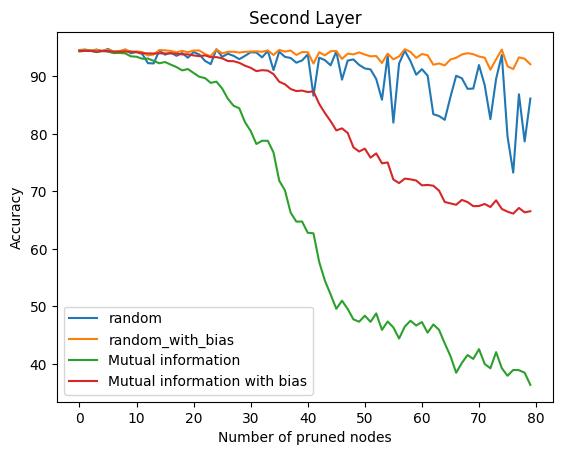

In [69]:
plt.plot(random_performances)
plt.plot(random_bias_performances)
plt.plot(MI_performances)
plt.plot(MI_bias_performances)
plt.title("Second Layer")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "random_with_bias", "Mutual information", "Mutual information with bias"])
plt.show()

### Third layer

In [70]:
random_performances = []
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) + 400
    random_idx = torch.from_numpy(random_idx).cuda()
    mask1 = torch.ones((600,1), device='cuda')
    mask1[random_idx] = 0
    random_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [71]:
MI_performances = []
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_3st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 400
    mask1 = torch.ones((600,1), device='cuda')
    mask1[idx] = 0
    MI_performances.append(cal_performance(Net, test_loader, mask1))
 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

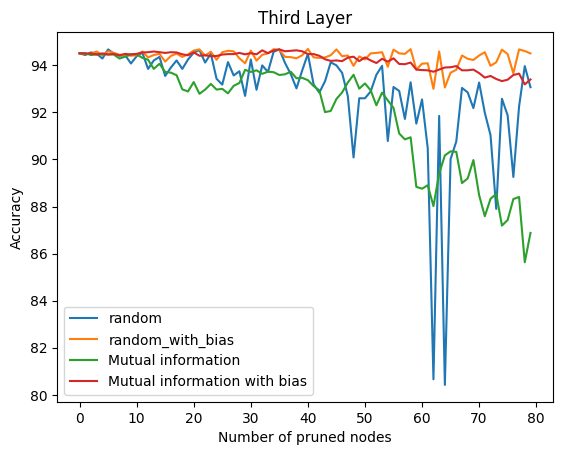

In [72]:
plt.plot(random_performances)
plt.plot(random_bias_performances)
plt.plot(MI_performances)
plt.plot(MI_bias_performances)
plt.title("Third Layer")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "random_with_bias", "Mutual information", "Mutual information with bias"])
plt.show()

## Whole-Network ablation (Fig 3)

In [80]:
Entropy = torch.cat((Entropy_1st, Entropy_2st, Entropy_3st),0).unsqueeze(-1)
MI = torch.cat((MI_1st, MI_2st, MI_3st),0)
KL_sel = torch.cat((KL_sel_1st, KL_sel_2st, KL_sel_3st),0)
p = torch.cat((p_1st, p_2st, p_3st),0)

In [81]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(600), size= n_abl+1, replace = False)
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [82]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):

    idx = torch.topk(MI, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [83]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):

    idx = torch.topk(KL_sel, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1)  
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [84]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):

    idx = torch.topk(Entropy, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1)  
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

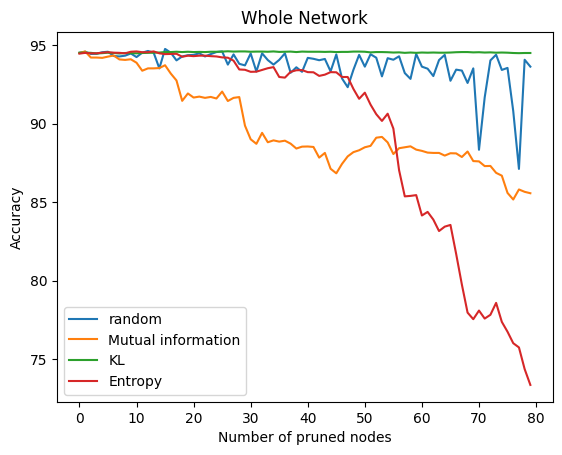

In [85]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("Whole Network")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

## Layer-wise Ablation (Fig 4)

### First Layer

#### High values first

In [90]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False)
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [91]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_1st, n_abl+1 , dim= 0)[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [92]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_1st, n_abl+1 , dim= 0)[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [93]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_1st, n_abl+1 , dim= 0)[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

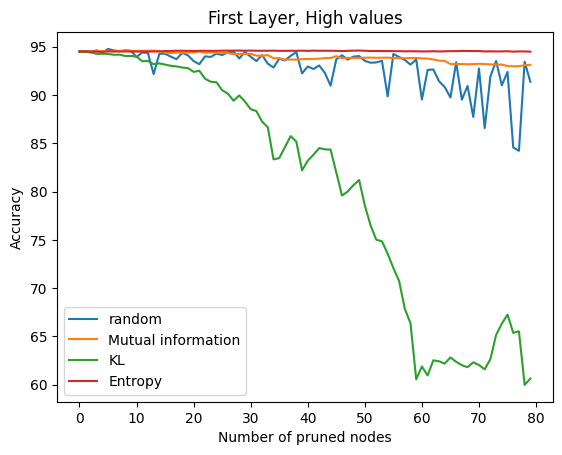

In [94]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("First Layer, High values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

#### Low values first

In [95]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False)
    random_idx = torch.from_numpy(random_idx).cuda() 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [96]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_1st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [97]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_1st, n_abl+1 , dim= 0, largest = False )[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [98]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_1st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1)
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

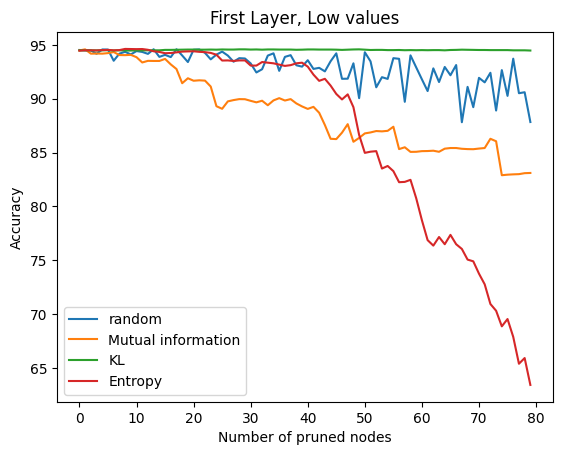

In [99]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("First Layer, Low values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

### Second Layer

#### High values first

In [101]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) +200
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [102]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_2st, n_abl+1 , dim= 0)[1].squeeze(-1) + 200
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [103]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_2st, n_abl+1 , dim= 0)[1].squeeze(-1) + 200 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [104]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_2st, n_abl+1 , dim= 0)[1].squeeze(-1) + 200
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

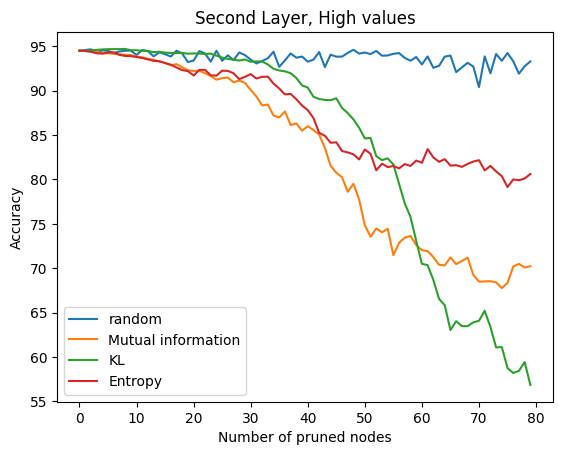

In [105]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("Second Layer, High values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

#### Low values first

In [106]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) + 200
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [107]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_2st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 200
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [108]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_2st, n_abl+1 , dim= 0, largest = False )[1].squeeze(-1)+ 200
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [109]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_2st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 200
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

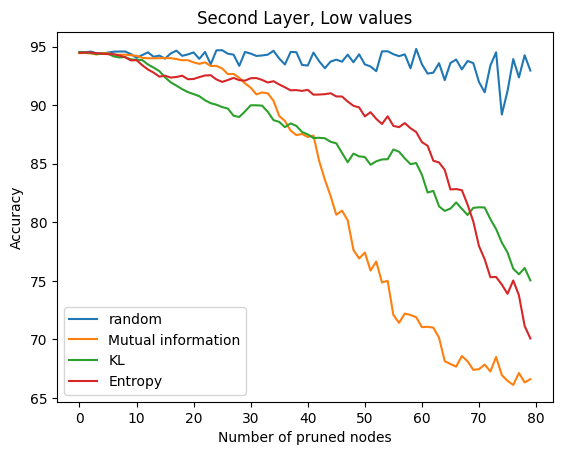

In [110]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("Second Layer, Low values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

### Third Layer

#### High values first

In [111]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) + 400
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [112]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_3st, n_abl+1 , dim= 0)[1].squeeze(-1) + 400
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [113]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_3st, n_abl+1 , dim= 0)[1].squeeze(-1) + 400 
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [114]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_3st, n_abl+1 , dim= 0)[1].squeeze(-1) + 400
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

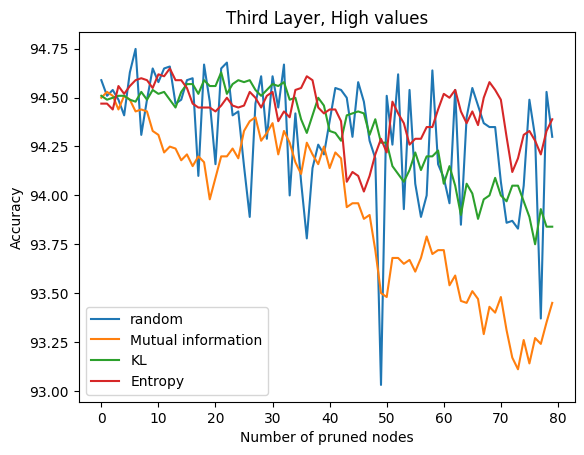

In [115]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("Third Layer, High values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()

#### Low values first

In [116]:
random_bias_performances = []

for n_abl in tqdm(range(80)):
    random_idx = np.random.choice(np.arange(200), size= n_abl+1, replace = False) + 400
    random_idx = torch.from_numpy(random_idx).cuda()
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[random_idx,0] = torch.index_select(p_cuda, 0, random_idx)[:,1]
    random_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [117]:
MI_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(MI_3st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 400
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    MI_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [118]:
KL_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(KL_sel_3st, n_abl+1 , dim= 0, largest = False )[1].squeeze(-1)+ 400
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    KL_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

In [119]:
Entropy_bias_performances = []

for n_abl in tqdm(range(80)):
    idx = torch.topk(Entropy_3st, n_abl+1 , dim= 0, largest = False)[1].squeeze(-1) + 400
    mask2 = torch.ones((600,1), device='cuda')
    p_cuda = p.cuda()
    mask2[idx,0] = torch.index_select(p_cuda, 0, idx)[:,1]
    Entropy_bias_performances.append(cal_performance(Net, test_loader, mask2))

  0%|          | 0/80 [00:00<?, ?it/s]

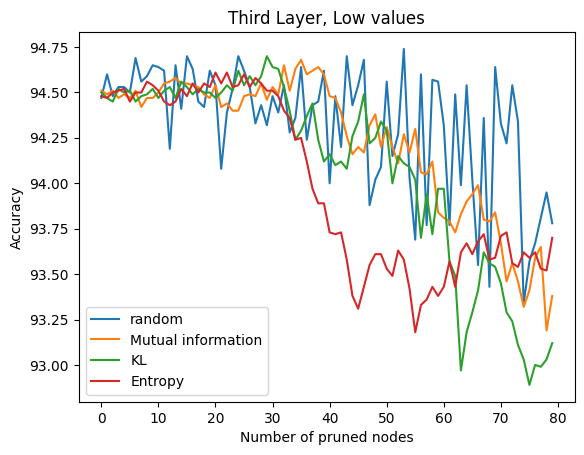

In [120]:
plt.plot(random_bias_performances)
plt.plot(MI_bias_performances)
plt.plot(KL_bias_performances)
plt.plot(Entropy_bias_performances)
plt.title("Third Layer, Low values")
plt.ylabel('Accuracy')
plt.xlabel('Number of pruned nodes')
plt.legend(labels = ["random", "Mutual information", "KL", "Entropy"])
plt.show()